# DSCI 550 Assignment 1

Wednesday January 24, 2021

Olivia Fryt : fryt@usc.edu

## 1. Download/Install Apache Tika

##### Start GeoTopicParser-enabled Tika Server:

Run a GeoTopicParser-enabled Apache Tika Server on localhost:9998. Containerized in my repo: https://github.com/frytoli/geotopic-parser-enabled-tika-docker
```
docker run -d -p 127.0.0.1:9998:9998 fryto/gtp-tika:latest
```

##### Python Options:

Install python Tika:
```
pip install tika
```

## 2. Download/Install D3.js

http://d3js.org/

Visual gallery wiki: https://github.com/mbostock/d3/wiki/Tutorials 

## 3. Download Nigerian Price Fraud Email Dataset

Source: https://www.kaggle.com/rtatman/fraudulent-email-corpus

Local Paths: ./data/fraudulent_emails.txt, ./data/fraudulent_emails_copy.txt

In [1]:
import os

infile = 'fraudulent_emails_copy.txt'
path_to_infile = os.path.join(os.getcwd(), 'data', infile)

outfile = 'fraudulent_emails.json'
path_to_outfile = os.path.join(os.getcwd(), 'data', outfile)

In [2]:
# Prepare method to save a checkpoint of the data to the "outfile"
import json

def save_to_outfile(data):
    with open(path_to_outfile, 'w') as outjson:
        json.dump(data, outjson, indent=2)
    print(f'Data saved to {path_to_outfile}')

## 4. Convert Dataset into Json

### 4.1. "Convert" messages to json with Tika

** NOTE:

Use of the Tika CLI yields different (and better) results than directly using the API to parse files. I can't figure out why this is. The Tika python CLI "parse" command uses the ```parseAndSave()``` method (https://github.com/chrismattmann/tika-python/blob/d692c0ffa6b85d099019de9b94888fb4c2a48040/tika/tika.py#L261) that in turn sends data to the parse1() method (https://github.com/chrismattmann/tika-python/blob/d692c0ffa6b85d099019de9b94888fb4c2a48040/tika/tika.py#L310) which interfaces with Tika to complete parsing. Interestingly enough, the ```from_file()``` parsing method in the Tika python library (https://github.com/chrismattmann/tika-python/blob/d692c0ffa6b85d099019de9b94888fb4c2a48040/tika/parser.py#L23) also passes data through the ```parse1()``` method to Tika. The only main difference between ```parseAndSave()``` and ```from_file()``` is the way the output data is handled and returned: the ```parseAndSave()``` method simply writes the item at index 1 in the returned json on a new line while the ```from_file()``` method sends the data returned from Tika to the ```_parse()``` method (https://github.com/chrismattmann/tika-python/blob/d692c0ffa6b85d099019de9b94888fb4c2a48040/tika/parser.py#L68) for additional parsing

In [4]:
#import sys
#!{sys.executable} -m pip install tika
import tika
from tika import tika

parsed = json.loads(tika.parse1('all', path_to_infile)[1])

# Ignore the first returned item, as it is associated with the infile
messages = parsed[1:]

# Save a checkpoint
save_to_outfile(messages)

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/dsci550-assignment1/data/fraudulent_emails.json


### 4.2. Ensure each message is a separate json entity

** Addition of new key ```embedded_resources```

In [5]:
# Find and attribute message attachments (these are parsed as separate json blobs)
#   * Attachment (embedded resource) metadata is stored in the json object(s) directly before the main message object in the list returned from Tika
resource_indicies = []
resources = []
count = 0
for message in messages:
    # If at least one resource needs to be added...
    if len(resources) > 0:
        # If there seems to be another resource attached to the same message, append it to resources, save item index, and continue
        if message['X-TIKA:embedded_depth'] != '1':
            resource_indicies.append(count)
            resources.append(message)
        # Else if the current message is the main message (aka it is not an embedded message)...
        elif message['X-TIKA:embedded_depth'] == '1':
            # Iterate over the resources...
            for resource in resources:
                # Assume the message (as long as it's immediately after the attachment(s)) is associated with the attachment(s)
                if 'embedded_resources' not in message:
                    message['embedded_resources'] = [resource]
                else:
                    message['embedded_resources'].append(resource)
            # Reset
            resources = []
        else:
            print('[!] Houston we have a problem')
            # Reset
            resources = []
    # Otherwise, check if the current message is an embedded resource
    elif message['X-TIKA:embedded_depth'] != '1':
        resource_indicies.append(count)
        resources = [message]
    # Increment the counter
    count += 1

# Remove messages that are embedded resources -- best practice is not to manipulate a list while iterating over it
delta = 0
for index in resource_indicies:
    del messages[index-delta]
    delta +=1

print(f'{len(resource_indicies)} embedded resources attributed to {len(messages)} total messages')

# Save a checkpoint
save_to_outfile(messages)

51 embedded resources attributed to 3978 total messages
Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/dsci550-assignment1/data/fraudulent_emails.json


## 5. Dataset Enrichment with Attack Type and Attacker Stylometrics

### 5.1. Attack Type Classification

Begin by generating a word cloud to gain insight into the content of the messages:

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/dsci550-assignment1/data/fraudulent_emails.json


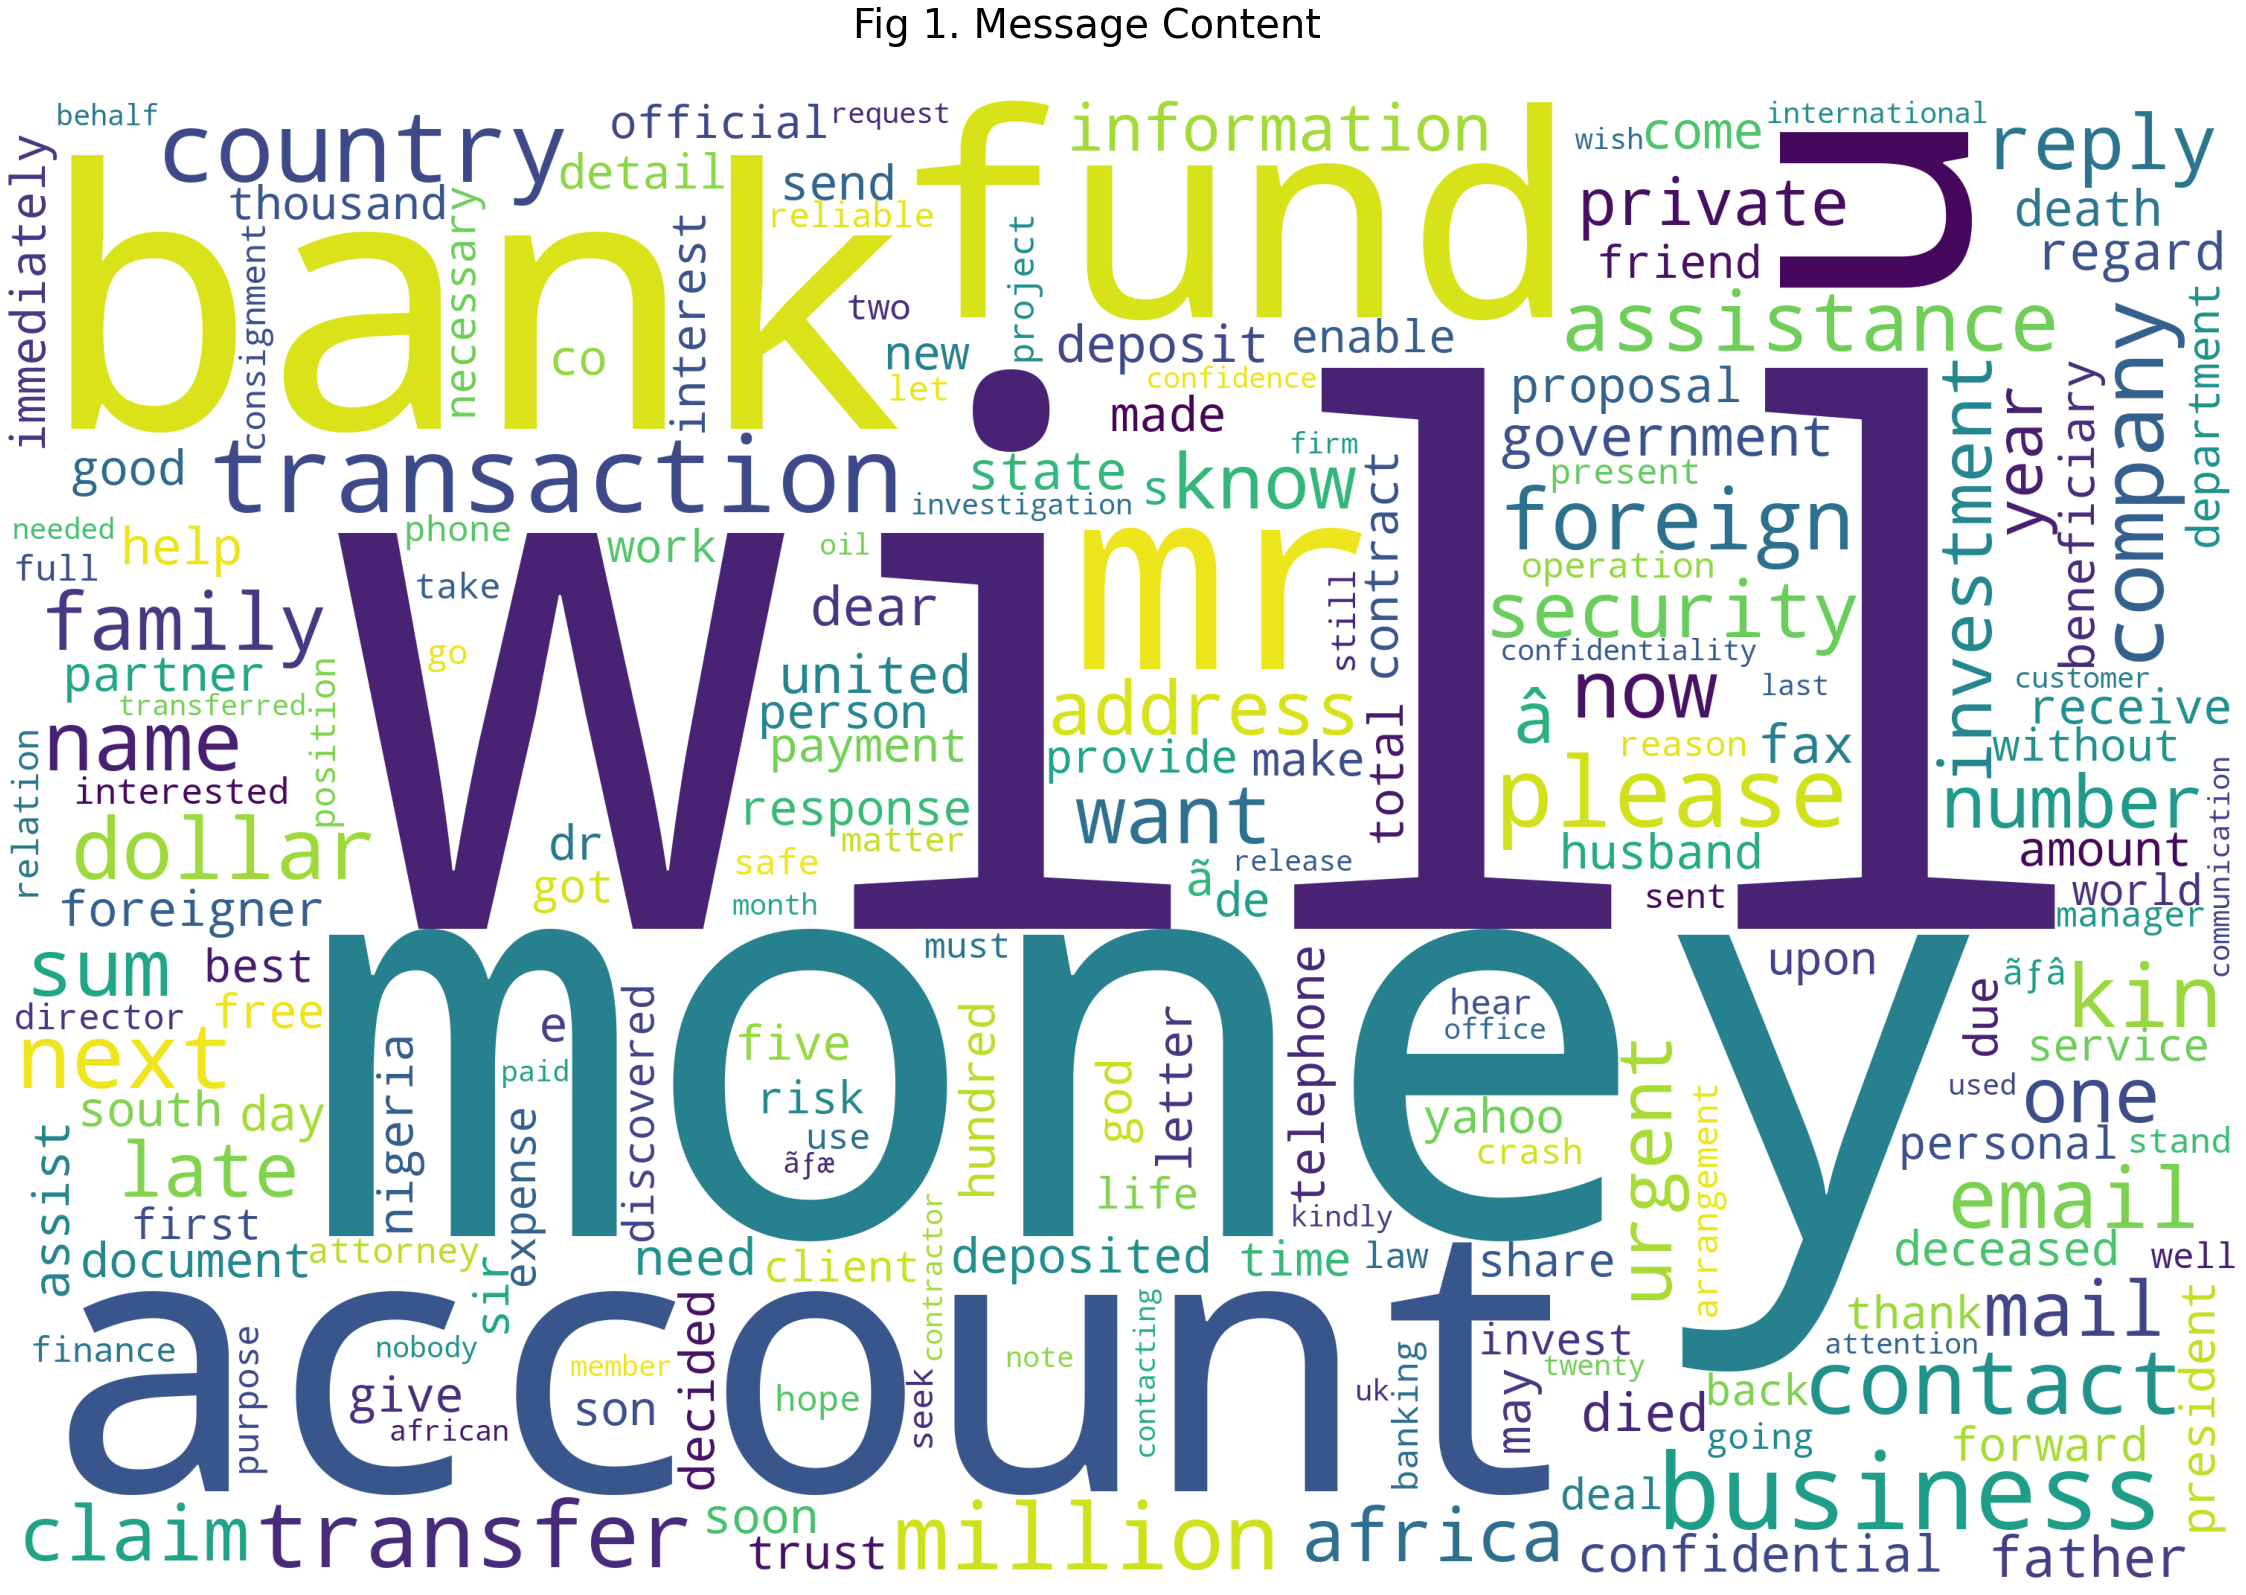

In [6]:
#import sys
#!{sys.executable} -m pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Join and normalize all message contents and message subjects as strings
cloud_corpus = ''
for message in messages:
    # Append body to word cloud corpus
    cloud_corpus = f'''{cloud_corpus} {message['X-TIKA:content'].lower().strip()}'''
    # Append subject to word cloud corpus, if applicable
    if 'subject' in message:
        cloud_corpus = f'''{cloud_corpus} {message['subject'].lower().strip()}'''

# Save a checkpoint
save_to_outfile(messages)

# Generate word cloud
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(STOPWORDS),
    random_state = 1,
    collocations = False
).generate(str(cloud_corpus))

# Plot
fig = plt.figure(1, figsize=(40, 30))
plt.axis('off')
fig.suptitle('Fig 1. Message Content', fontsize=40)
fig.subplots_adjust(top=1.06)

plt.imshow(wordcloud)
plt.show()


Categorize the messages into the following social engineering types by (1) scanning a compiled set of keywords and (2) recognizing suspicious attachments/resources (in other words, messages with an attachment are considered to be of SE type "malware"):

SE Types: Reconnaissance, Social Engineering, Malware, Phishing

** NOTE: Intelligent categorization into these four categories is not possible without training data (must be supervised).

In [7]:
keywords = {
    'recon': ['reply back', 'click here', 'confidential', 'contact', 'response', 'private', 'personal', 'information'],
    'social_engineering': ['your friend', 'comrade', 'urgent', 'need help', 'threat', 'act now', '$', 'money', 'transaction', 'give', 'assist', 'business', 'fund', 'help', 'unclaimed', 'please', 'died'],
    'malware': ['click here', 'http'],
    'phishing': ['social security', 'ssn', 'date of birth', 'birthday', 'dob', 'account number', 'bank', 'beneficiary', 'password', 'phone number', 'fax number', 'company address']
}

# Keep count of keywords to get more insight/clean keywords
kw_count = {kw:0 for kw in keywords}

# Tag messages
for message in messages:
    message['se_tags'] = [] # Set would be easier, but isn't json serializable
    for kw_type in keywords:
        for kw in keywords[kw_type]:
            if kw in message['X-TIKA:content']:
                if kw_type not in message['se_tags']:
                    message['se_tags'].append(kw_type)
                    kw_count[kw_type] += 1
    # If the message contains at least one attachment, classify it as "malware"
    if 'embedded_resources' in message:
        if 'malware' not in message['se_tags']:
            message['se_tags'].append('malware')
            kw_count['malware'] += 1
        

print('Count of messages by tag:')
for kw in sorted(kw_count, key=kw_count.get, reverse=True):
    print(f'  {kw}: {kw_count[kw]}')

# Save a checkpoint
save_to_outfile(messages)

Count of messages by tag:
  social_engineering: 3860
  recon: 3348
  phishing: 2624
  malware: 1351
Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/dsci550-assignment1/data/fraudulent_emails.json


### 5.2. Attacker Stylometric Enrichment

#### 5.2.1. Find attacker title

** NOTE: Named entity recognition with NLTK does not notice titles without personalization. Therefore, fuzzy string matching was utilized.

In [9]:
#import sys
#!{sys.executable} -m pip install fuzzywuzzy python-Levenshtein
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import re

# Define a set of sender titles
titles = ['mr', 'mrs', 'miss', 'ms', 'madame', 'honourable', 'lady', 'senator', 'governor', 'hon', 'col', 'colonel',
          'president', 'partner', 'senior', 'ceo', 'executive', 'officer', 'chief', 'maitre', 'dr', 'doctor', 'barr',
          'barrister', 'esq', 'esquire', 'manager', 'executive', 'sister', 'brother', 'captain', 'capt', 'head', 'lead',
          'director', 'prince', 'princess', 'king', 'queen', 'chairman', 'judge', 'engr', 'engineer', 'minister']
abrv_titles = {
    'dr': 'doctor',
    'barr': 'barrister',
    'esq': 'esquire',
    'capt': 'captain',
    'engr': 'engineer',
    'ceo': 'chief executive officer',
    'hon': 'honourable',
    'col': 'colonel'
}
# Note that CEO is a bit strange, as the title can be set from three different titles
#  ceo = all(['chief', 'executive', 'officer'])

# Iterate over messages
for message in messages:
    # Create "author_titles" key-value pair
    message['author_titles'] = []
    temp_titles = set()
    # Fuzzy match author name, if applicable
    if 'Author' in message:
        # If applicable, pick last author in author string to fuzzy match on (this item seems to have been parsed more cleanly by Tika)
        if len(message['Author']) > 1:
            author = message['Author'][-1].lower()
        else:
            author = message['Author'][0].lower()
        # Split author string by space, period, comma, and dash, and normalize (lowercase)
        split_author = re.split('[ .,-]', author.lower())
        # Iterate over titles
        for title in titles:
            # Iterate over split parts of author
            for part in split_author:
                # Fuzzy match the parse parts of the author string with each title
                ratio = fuzz.ratio(title, part)
                if ratio > 86: # 86 seems to be the threshold at which "mrs" != "mr" and "prince" != "princess"
                    # Add title to set
                    temp_titles.add(title)
    # If not title was found in the author name or an author name does not exist, separate message content at last comma, split, and fuzzy match
    if 'Author' not in message or len(temp_titles) == 0:
        indexof_last_comma = message['X-TIKA:content'].rfind(',')
        endof_body = message['X-TIKA:content'][indexof_last_comma+1:]
        # Split string by space, period, comma, and dash, and normalize (lowercase)
        split_endof_body = re.split('[\s.,\-()]', endof_body.lower())
        # Iterate over titles
        for title in titles:
            # Iterate over split parts of body
            for part in split_endof_body:
                # Fuzzy match the parse parts of the author string with each title
                ratio = fuzz.ratio(title, part)
                if ratio > 86: # 86 seems to be the threshold at which "mrs" != "mr" and "prince" != "princess"
                    # Add title to set
                    temp_titles.add(title)
    # Make titles consistent (handle abbreviations)
    # First a foremost, lets see if author is a ceo ** Note the comment above
    ceo_check = all(item in list(temp_titles) for item in ['chief', 'executive', 'officer'])
    if ceo_check:
        temp_titles.add('ceo')
        temp_titles.remove('chief')
        temp_titles.remove('executive')
        temp_titles.remove('officer')
    # Iterate over titles and add to message blob
    for title in temp_titles:
        try:
            message['author_titles'].append(abrv_titles[title])
        except:
            message['author_titles'].append(title)

# Save a checkpoint
save_to_outfile(messages)

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/dsci550-assignment1/data/fraudulent_emails.json


#### 5.2.2. Attribute a level of urgency ("urgency score") to each message

In [10]:
# Synonyms/antonyms of "urgent" from thesaurus.com: https://www.thesaurus.com/browse/urgent
#  Some words removed to avoid confusion, mainly in regards to sender titles i.e. "chief" and "principal"
#  Some words added after manual review of messages

urgency_ratings = {
    2: ['urgency', 'urgent', 'compelling', 'compel', 'critical', 'crucial', 'demanding', 'essential', 'immediate',
        'imperative', 'important', 'indispensable', 'necessary', 'persuasive', 'pressing', 'serious', 'vital', 'weighty',
        'as soon as possible', 'may not exceed', 'now'],
    1: ['burning', 'called-for', 'clamant', 'clamorous', 'crying', 'demanded', 'driving', 'exigent', 'foremost', 'heavy',
        'hurry-up', 'impelling', 'importunate', 'insistent', 'instant', 'leading', 'life and death', 'momentous', 'paramount',
        'primary', 'required', 'salient', 'top-priority', 'touch and go', 'touchy', 'wanted', 'quick', 'earliest response',
        'at once', 'right now'],
    -1: ['easy', 'facile', 'inessential', 'insignificant', 'light', 'minor', 'needless', 'nonessential', 'optional',
         'secondary', 'small', 'trivial', 'uncritical', 'unimportant', 'unnecessary', 'unsubstantial', 'voluntary',
         'eventually', 'later']
}

scores = []

# Iterate over messages
for message in messages:
    # Iterate over words in urgency ratings, see if they exist in the message's body, and compile a score accordingly
    message['urgency_score'] = 0
    for score in urgency_ratings:
        for word in urgency_ratings[score]:
            # If the word is found in the message's body content, add the associated score (note that antonyms take away from the overall urgency score)
            if word in message['X-TIKA:content'].lower():
                message['urgency_score'] += score
    scores.append(message['urgency_score'])

# Output max, avg, min of scores
print(f'Max "urgency score": {max(scores)}')
print(f'Avg "urgency score": {sum(scores)/len(scores)}')
print(f'Min "urgency score": {min(scores)}')

# Save a checkpoint
save_to_outfile(messages)

Max "urgency score": 15
Avg "urgency score": 4.414278531925591
Min "urgency score": -2
Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/dsci550-assignment1/data/fraudulent_emails.json


#### 5.2.3. Find the date/time of the email attack

** This was moved to AFTER the geolocation discovery **

Convert "Creation-Date" (all in Zulu time) to ISO 8601 format string

#### 5.2.4. Categorize (tag) the attacker's offerring

Offerrings: percentage of money, lump-sum of money, religious benefit, investment management opportunity, product for sale, loan, bank account, social media invitation (invitation from facebox), 

Start by using k-means clustering to find natural clusters based on language to gain insight into the individual meanings behind the messages:

Categorize the messages:

In [137]:
for message in messages:
    if 'percent' not in message['X-TIKA:content'] and '%' not in message['X-TIKA:content'] and 'share' not in message['X-TIKA:content'] and '$' not in message['X-TIKA:content'] and 'dollars' not in message['content-body'] and 'God' not in message['X-TIKA:content']:
        print(message['X-TIKA:content'])

Attn:

I write to you of my desire to do business with
your establishment. I am Dr. Arturo Ramitez A sailor
from dominican Republic and I am very interested in
investing in any viable business venture that would be
of mutual benefits to us both, with funds that are
currently avaliable to me.

I would be very much delighted if you would be kind
enough to reply to my Proposal.Send your response to my email address
so that we could both discuss the possiblity of doing business together.



When I  heard from you, I will then discuss further details of my funds as
well as areas of possible investment ideas that you may suggest
to me.Looking forward to hearing from you.

Best Regards.

Dr. Don Arturo Ramitez.






solo chuks
16 Kingsway Road 
Ikoyi,Lagos.
 
Dear sir,

Greetings to you and yourfamily. I will need your assistance in investing in 
your country. Real Estate and importation into my country. But due to my 
position as a civil servant I will need someone to assist me with this as

#### 5.2.5. Identify attacker's (sender's) geolocation with geoNames.txt

Use GeoTopicParser in Tika: https://cwiki.apache.org/confluence/display/tika/GeoTopicParser

** NOTES:

Was unable to get GeoTopicParser to work with Python Tika, so I put together and am using a containerized GeoTopicParser-enabled Tika Server (my repo: https://github.com/frytoli/geotopic-parser-enabled-tika-docker). Run this in the background (see step 1 above), then run code below:

Find geolocations mentioned in each message's content with Tika's GeoLocationParser:

In [11]:
import requests

# Define method for communicating with GeoTopicParser-enabled Tika Server
def geotopicparse_file(filename, filedata):
    headers = {
        'Content-Disposition': f'attachment; filename={filename}'
    }
    r = requests.put('http://localhost:9998/rmeta', headers=headers, data=filedata)
    if r.status_code == 200:
        return r.json()

#resp = geotopicparse_file('./tika-docker/polar.geot', 'polar.geot')
#print(resp)

whitespace_ptrn = re.compile(r'\s')

# Iterate over messages
for message in messages:
    # Normalize all whitespace in message body
    norm_content = whitespace_ptrn.sub(r' ', message['X-TIKA:content']).encode('utf-8')
    # Parse each message content for geotopics
    parsed = geotopicparse_file('message.geot', norm_content)
    # Save extracted geolocations to message json
    message['GeoLocationParser-data'] = parsed

# Save a checkpoint
save_to_outfile(messages)

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/dsci550-assignment1/data/fraudulent_emails.json


Find geolocation based off of sender IP addresses using IPInfo (https://github.com/ipinfo/python) (note that IP addresses change, so this data might not be entirely accurate):

In [12]:
#import sys
#!{sys.executable} -m pip install ipinfo
import ipinfo

# Initialize ipinfo object and handler
ipinfo_token = 'eb65e70ef00bb6' # 50,000 free requests per month
handler = ipinfo.getHandler(ipinfo_token)

# Iterate over messages
for message in messages:
    if 'MboxParser-x-sender-ip' in message:
        # Get ip address details from ipinfo
        details = handler.getDetails(message['MboxParser-x-sender-ip'].strip())
        # Retrieve and save all detail information
        message['IPInfo-data'] = details.all

# Save a checkpoint
save_to_outfile(messages)    

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/dsci550-assignment1/data/fraudulent_emails.json


#### 5.2.3. Find the date/time of the email attack

Convert "Creation-Date" (all in Zulu time) to ISO 8601 format string

In [12]:
#import sys
#!{sys.executable} -m pip install python-dateutil
from dateutil import parser

nodate = []

# Iterate over messages
for message in messages:
    # If "Creation-Date" in message record, convert value directly to isoformat
    if 'Creation-Date' in message:
        # Convert "Creation-Date" to ISO 8601 and store in *** new key "timestamp" ***
        message['timestamp'] = parser.isoparse(message['Creation-Date']).isoformat()
    # Otherwise, if "MboxParser-from" in message record, convert this value to isoformat AND use previously discovered geolocation for timezone
    elif 'MboxParser-from' in message:
        # Prioritize IP address timezone, then Tika GeoTopicParser locations
        
    else:
        print('[!] Houston we have a problem')

#### 5.2.6. Evaluate the attacker's alleged relationship to the recipient

In [ ]:
# Start with greeting


#### 5.2.7. Analyze attacker's message sentiment

https://github.com/USCDataScience/SentimentAnalysisParser

#### 5.2.8. Analyze attacker's language style

##### Evaluate ratio of misspelled words
https://github.com/mammothb/symspellpy

In [10]:
#import sys
#!{sys.executable} -m pip install symspellpy
import pkg_resources
from symspellpy import SymSpell, Verbosity

# Initialize symspell object
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Find and load the dictonary resources
dictionary_path = pkg_resources.resource_filename('symspellpy', 'frequency_dictionary_en_82_765.txt')
bigram_path = pkg_resources.resource_filename('symspellpy', 'frequency_bigramdictionary_en_243_342.txt')
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Compile regex patterns to ignore in message body contents
email_ptrn = re.compile(r'(?!_)[\w]{1,11}@(?![_\-.])[\w]{1,11}(\.[a-zA-Z]{1,10}){1,2}')
phone_ptrn = ''
addrs_ptrn = ''

# Iterate over messages and find incorrect spellings
for message in messages:
    suggestions = sym_spell.lookup_compound(message['content-body'], max_edit_distance=2, transfer_casing=True)
    print(message['content-body'])
    print('\n')
    for suggestion in suggestions:
        print(suggestion)
    break

FROM:MR. JAMES NGOLA.
CONFIDENTIAL TEL: 233-27-587908.
E-MAIL: (james_ngola2002@maktoob.com).

URGENT BUSINESS ASSISTANCE AND PARTNERSHIP.


DEAR FRIEND,

I AM ( DR.) JAMES NGOLA, THE PERSONAL ASSISTANCE TO THE LATE CONGOLESE (PRESIDENT LAURENT KABILA) WHO WAS ASSASSINATED BY HIS BODY GUARD ON 16TH JAN. 2001.


THE INCIDENT OCCURRED IN OUR PRESENCE WHILE WE WERE HOLDING MEETING WITH HIS EXCELLENCY OVER THE FINANCIAL RETURNS FROM THE DIAMOND SALES IN THE AREAS CONTROLLED BY (D.R.C.) DEMOCRATIC REPUBLIC OF CONGO FORCES AND THEIR FOREIGN ALLIES ANGOLA AND ZIMBABWE, HAVING RECEIVED THE PREVIOUS DAY (USD$100M) ONE HUNDRED MILLION UNITED STATES DOLLARS, CASH IN THREE DIPLOMATIC BOXES ROUTED THROUGH ZIMBABWE.

MY PURPOSE OF WRITING YOU THIS LETTER IS TO SOLICIT FOR YOUR ASSISTANCE AS TO BE A COVER TO THE FUND AND ALSO COLLABORATION IN MOVING THE SAID FUND INTO YOUR BANK ACCOUNT THE SUM OF (USD$25M) TWENTY FIVE MILLION UNITED STATES DOLLARS ONLY, WHICH I DEPOSITED WITH A SECURITY COMPANY IN GH

#### Evaluate ratio of random capitalizations

#### 5.2.9. Attempt to estimate the attacker's age

https://github.com/USCDataScience/AgePredictor

#### 5.2.10. Discover if the message was sent from an address previously reported to be phisher

Example: https://scamalytics.com/ip

Can I use Viewdns?

## 6. Dataset Enrichment from Additional Datasets

Additional Datasets:
* SecurityTrails: https://securitytrails.com
* VirusTotal: https://www.virustotal.com
* Shodan: https://shodan.io
* ViewDNS: https://viewdns.info/